### Complete Guide for Transfer learning

Here I have used Caltech-101_object dataset but the basics of Transfer learning will remain same with other datasets.
We have to look about two things in our our dataset while using Transfer learning and these are:
1. Similarity of our dataset with that of pre-trained model
2. the amount of data we have
Based on these two we have to select which type of transfer learning we should use.

###### The target dataset is small and similar to the base training dataset.
Since the target dataset is small, it is not a good idea to fine-tune the ConvNet due to the risk of overfitting. Since the target data is similar to the base data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, we:
1. Remove the fully connected layers near the end of the pretrained base ConvNet
2. Add a new fully connected layer that matches the number of classes in the target dataset
3. Randomize the weights of the new fully connected layer and freeze all the weights from the pre-trained network
4. Train the network to update the weights of the new fully connected layers

###### The target dataset is large and similar to the base training dataset.
Since the target dataset is large, we have more confidence that we won’t overfit if we try to fine-tune through the full network. Therefore, we:

1. Remove the last fully connected layer and replace with the layer matching the number of classes in the target dataset
2. Randomly initialize the weights in the new fully connected layer
3. Initialize the rest of the weights using the pre-trained weights, i.e., unfreeze the layers of the pre-trained network
4. Retrain the entire neural network

###### The target dataset is small and different from the base training dataset.
Since the data is small, overfitting is a concern. Hence, we train only the linear layers. But as the target dataset is very different from the base dataset, the higher level features in the ConvNet would not be of any relevance to the target dataset. So, the new network will only use the lower level features of the base ConvNet. To implement this scheme, we:

1. Remove most of the pre-trained layers near the beginning of the ConvNet
2. Add to the remaining pre-trained layers new fully connected layers that match the number of classes in the new dataset
3. Randomize the weights of the new fully connected layers and freeze all the weights from the pre-trained network
4. Train the network to update the weights of the new fully connected layers

###### The target dataset is large and different from the base training dataset.
As the target dataset is large and different from the base dataset, we can train the ConvNet from scratch. However, in practice, it is beneficial to initialize the weights from the pre-trained network and fine-tune them as it might make the training faster. In this condition, the implementation is the same as in case 3.

In [2]:
# import libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import random as rn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import cv2                  
import numpy as np  
from keras.preprocessing.text import Tokenizer
import os                   
from random import shuffle  
from PIL import Image
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [3]:
#enter the path of your dataset directory.
# Here I have used only five classes from our dataset and these are
#airplanes, crayfish, butterfly, panda, crocodile
print(os.listdir('C:/Users/Abhishek Gupta/Desktop/caltech small dataset'))

['airplanes', 'butterfly', 'crayfish', 'crocodile', 'panda']


###### Preparing dataset

In [4]:
X=[]
Y=[]
airplanes_dir='C:/Users/Abhishek Gupta/Desktop/caltech small dataset/airplanes'
butterfly_dir='C:/Users/Abhishek Gupta/Desktop/caltech small dataset/butterfly'
crayfish_dir='C:/Users/Abhishek Gupta/Desktop/caltech small dataset/crayfish'
crocodile_dir='C:/Users/Abhishek Gupta/Desktop/caltech small dataset/crocodile'
panda_dir='C:/Users/Abhishek Gupta/Desktop/caltech small dataset/panda'

In [5]:
# here we have checked type of our images in our dataset.
#Since we are inputting 3 channels in our model so,images in our dataset must have 3 channels i.e.,RGB images.
img = cv2.imread('C:/Users/Abhishek Gupta/Desktop/caltech small dataset/airplanes/image_0005.jpg')
print(img.shape)

(176, 395, 3)


In [6]:
#defining function to make lables and training data
from tqdm import tqdm
IMG_SIZE= 120
def locate_label(img,img_typ):
    return img_typ

def train_data(img_typ,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=locate_label(img,img_typ)
        path=os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Y.append(str(label))

In [7]:
train_data('panda',panda_dir)
print(len(X))

100%|██████████| 38/38 [00:01<00:00, 29.64it/s]

38


In [8]:
train_data('crocodile',crocodile_dir)
print(len(X))

100%|██████████| 50/50 [00:01<00:00, 27.25it/s]

88


In [9]:
train_data('crayfish',crayfish_dir)
print(len(X))

100%|██████████| 70/70 [00:02<00:00, 29.83it/s]

158


In [10]:
train_data('butterfly',butterfly_dir)
print(len(X))

100%|██████████| 91/91 [00:02<00:00, 33.94it/s]

249


In [11]:
train_data('airplanes',airplanes_dir)
print(len(X))

100%|██████████| 800/800 [00:27<00:00, 29.16it/s]

1049


###### visualising some random images

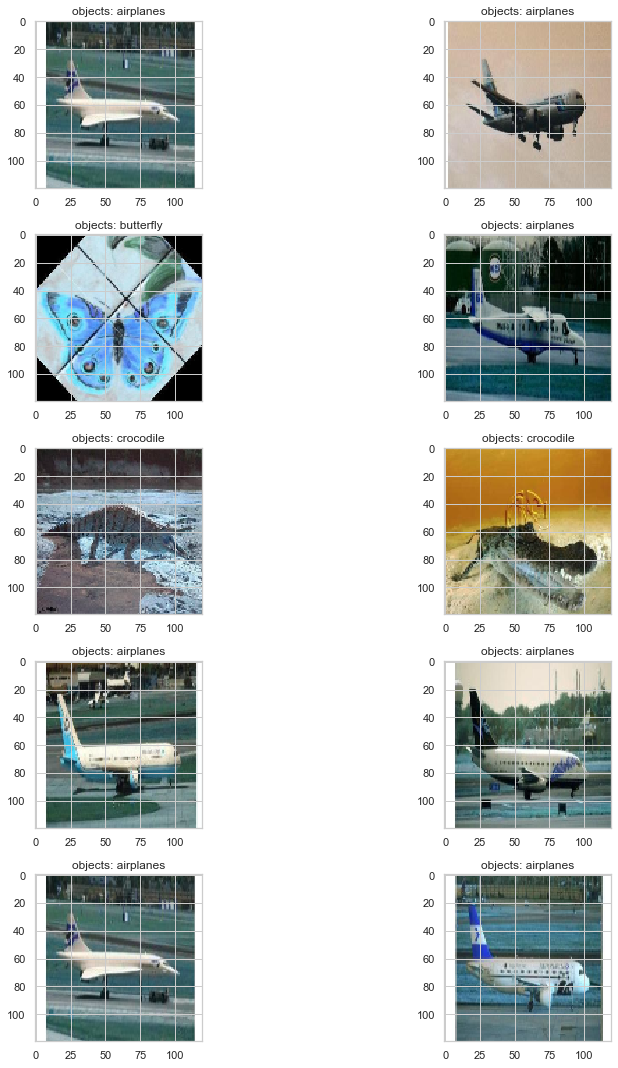

In [12]:
# here we have imbalanced dataset which certainly affects weights initialization but this is just a intuation about transfer learning 
# so we can ignore our imbalanced datset. Visualised some random images from training dataset
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('objects: '+Y[l])
        
plt.tight_layout()

###### lebelling and one hot-encoding 

In [13]:
#here we encoded our labels in five as we have selected 5 classese from our dataset.
le=LabelEncoder()
Z=le.fit_transform(Y)
Z=to_categorical(Z,5)
X=np.array(X)

X=X/255

###### splitting dataset 

In [14]:
#splitting dataset in training,testing set 
x_train,x_test,y_train,y_test=train_test_split(X,Z,test_size=0.25,random_state=10)

###### Data augmentation for avoiding overfitting of model

In [15]:
#avoiding overfitting with data augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

###### Importing VGG-16 model as our pretrained model with imagenet weights

In [16]:
#If you have weights downloaded explicitly remove comments and enter path by making weights None in place of imagenet
#weights_path='C:/Users/Abhishek Gupta/Desktop/19_model_weight/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
from keras.applications.vgg16 import VGG16
base_model=VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3), pooling='avg')
#base_model.load_weights(weights_path)

In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0     

###### Adding our own fully connected layers

In [29]:
model=Sequential()
model.add(base_model)
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

While using transfer learning in ConvNet; we have basically have 3 main approaches-->

1) To use the pretrained model as a feature extractor and just train your classifier on top of it. In this method we do not tune any weights of the model.

2) Fine Tuning- In this approach we tune the weights of the pretrained model. This can be done by unfreezing the layers that we want to train.In that case these layers will be initialised with their trained weights on imagenet.

3) Lasty we can use a pretrained model.

Note that in this section I have used the first approach ie I have just use the conv layers and added my own fully connected layers on top of VGG model. Thus I have trained a classifier on top of the CNN codes.

In [30]:
# freezed layers of imported model
base_model.trainable=False

In [31]:
batch_size=10
#red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)
model.summary()
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 132,613
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
78/78 [==============================] - 20s 262ms/step - loss: 1.7138 - accuracy: 0.2384 - val_loss: 1.4887 - val_accuracy: 0.7643
Epoch 2/50
78/78 [==============================] - 20s 254ms/step - loss: 1.3832 - accuracy: 0.8428 - val_loss: 1.1997 - val_accuracy: 0.8669
Epoch 3/50
78/78 [==============================] - 20s 254ms/step - loss: 1.1270 - accuracy: 0.8492 - val_loss: 0.9703 - val_accuracy: 0.8859
Epoch 4/50
78/78 [==============================] - 20s 254ms/step - loss: 0.9102 - accuracy: 0.8570 - val_loss: 0.7906 - val_accuracy: 0.9011
Epoch 5/50
78/78 [==============================] - 20s 254ms/step - loss: 0.7469 - accuracy: 0.8634 - val_loss: 0.6489 - val_accuracy: 0.9087
Epoch 6/50
78/78 [==============================] - 20s 254ms/step - loss: 0.6085 - accuracy: 0.8866 - val_loss: 0.5414 - val_accuracy: 0.9163
Epoch 7/50
78/78 [==============================] - 20s 254ms/step - loss: 0.5067 - accuracy: 0.8982 - val_loss: 0.4601 - val_accuracy: 0.9354

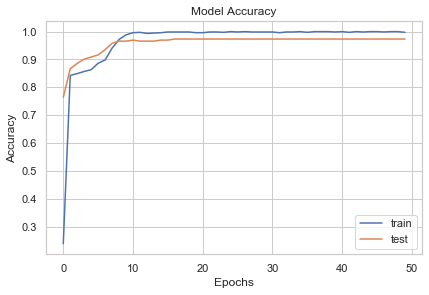

In [33]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['train', 'test'])
plt.show()

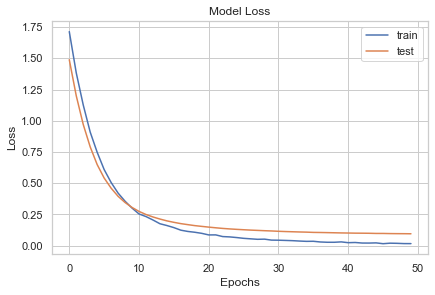

In [34]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

###### Fine Tuning of model by unfreezing last block of model
In this section I have done fine tuning. To see the effect of the fine tuning I have first unfreezed the last block of the VGG16 model and have set it to trainable. You can also unfreeze more layers according to need by replacing indexes in for loop.

In [25]:
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])
    
batch_size=10    
    
    
for layer in base_model.layers[15:]:
    layer.trainable=True
for layer in base_model.layers[0:15]:
    layer.trainable=False
    
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])    

0 <keras.engine.input_layer.InputLayer object at 0x00000222EDD1CE48>
1 <keras.layers.convolutional.Conv2D object at 0x00000222ECCBFC08>
2 <keras.layers.convolutional.Conv2D object at 0x00000222EDD0B988>
3 <keras.layers.pooling.MaxPooling2D object at 0x00000222EDD02F48>
4 <keras.layers.convolutional.Conv2D object at 0x000002229B0B3E88>
5 <keras.layers.convolutional.Conv2D object at 0x000002229B0BF248>
6 <keras.layers.pooling.MaxPooling2D object at 0x000002229B0E9F48>
7 <keras.layers.convolutional.Conv2D object at 0x000002229B0BFF48>
8 <keras.layers.convolutional.Conv2D object at 0x000002229B120108>
9 <keras.layers.convolutional.Conv2D object at 0x000002229B15E748>
10 <keras.layers.pooling.MaxPooling2D object at 0x000002229B18C948>
11 <keras.layers.convolutional.Conv2D object at 0x000002229B18CD48>
12 <keras.layers.convolutional.Conv2D object at 0x000002229B1A7588>
13 <keras.layers.convolutional.Conv2D object at 0x000002229B1F8708>
14 <keras.layers.pooling.MaxPooling2D object at 0x000002

In [26]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
78/78 [==============================] - 27s 348ms/step - loss: 0.1022 - accuracy: 0.9807 - val_loss: 0.0549 - val_accuracy: 0.9848
Epoch 2/50
78/78 [==============================] - 26s 337ms/step - loss: 0.0651 - accuracy: 0.9832 - val_loss: 0.0576 - val_accuracy: 0.9886
Epoch 3/50
78/78 [==============================] - 26s 337ms/step - loss: 0.0799 - accuracy: 0.9820 - val_loss: 0.0588 - val_accuracy: 0.9848
Epoch 4/50
78/78 [==============================] - 26s 337ms/step - loss: 0.1514 - accuracy: 0.9601 - val_loss: 0.0655 - val_accuracy: 0.9810
Epoch 5/50
78/78 [==============================] - 27s 340ms/step - loss: 0.0959 - accuracy: 0.9755 - val_loss: 0.0718 - val_accuracy: 0.9848
Epoch 6/50
78/78 [==============================] - 27s 340ms/step - loss: 0.0448 - accuracy: 0.9936 - val_loss: 0.0648 - val_accuracy: 0.9848
Epoch 7/50
78/78 [==============================] - 26s 338ms/step - loss: 0.0779 - accuracy: 0.9781 - val_loss: 0.0452 - val_accuracy: 0.9886

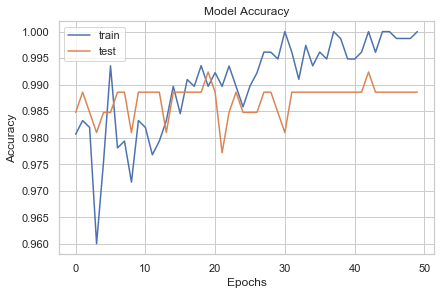

In [27]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

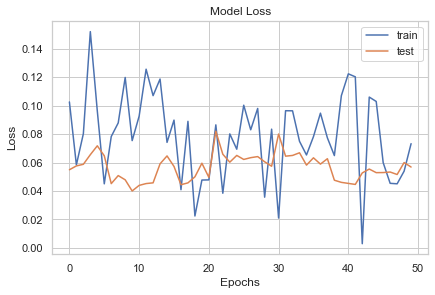

In [28]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

###### model from scratch.
Since our dataset is small and may lead to overfitting of model

In [21]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))


for layer in base_model.layers:
    layer.trainable=True
    
batch_size=10    

model.summary()
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1285      
Total params: 14,848,325
Trainable params: 14,847,813
Non-trainable params: 512
_________________________________________________________________


In [22]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)


Epoch 1/50
78/78 [==============================] - 65s 840ms/step - loss: 1.1947 - accuracy: 0.5657 - val_loss: 0.6707 - val_accuracy: 0.8403
Epoch 2/50
78/78 [==============================] - 52s 673ms/step - loss: 0.5910 - accuracy: 0.8402 - val_loss: 0.4921 - val_accuracy: 0.9468
Epoch 3/50
78/78 [==============================] - 52s 662ms/step - loss: 0.4220 - accuracy: 0.8930 - val_loss: 0.3324 - val_accuracy: 0.9506
Epoch 4/50
78/78 [==============================] - 54s 691ms/step - loss: 0.4183 - accuracy: 0.8930 - val_loss: 0.3720 - val_accuracy: 0.9125
Epoch 5/50
78/78 [==============================] - 53s 683ms/step - loss: 0.2581 - accuracy: 0.9446 - val_loss: 0.1722 - val_accuracy: 0.9734
Epoch 6/50
78/78 [==============================] - 52s 664ms/step - loss: 0.3166 - accuracy: 0.9214 - val_loss: 0.1623 - val_accuracy: 0.9506
Epoch 7/50
78/78 [==============================] - 52s 672ms/step - loss: 0.3176 - accuracy: 0.9034 - val_loss: 0.1369 - val_accuracy: 0.962

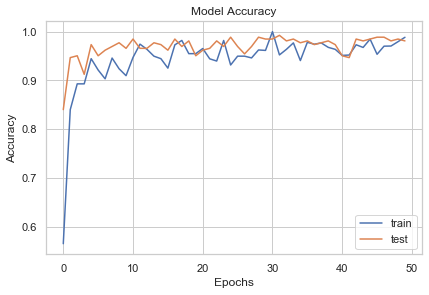

In [23]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

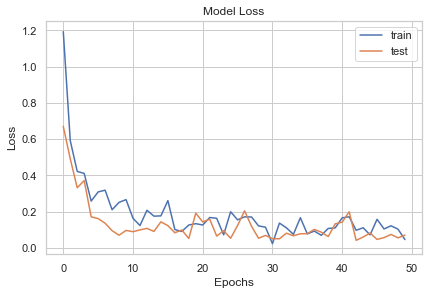

In [24]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
del model
K.clear_session()